# Orchestration Agent: Report Generator

This Jupyter notebook demonstrates an orchestration agent using LangGraph to generate a structured report on a given topic. The agent coordinates multiple steps: planning report sections, writing content for each section, and compiling the final report.

The workflow uses a `StateGraph` to manage shared state across nodes (agents). This example showcases sequential orchestration, with an optional async parallel version for section writing.

**Key Concepts:**
- Shared state with `TypedDict`
- LLM-powered agents for planning, writing, and compiling
- Graph construction with nodes and edges
- Synchronous and asynchronous execution

Ensure you have an `OPENROUTER_API_KEY` environment variable set for the LLM to work.

## 1. Imports and State Definition

We start by importing necessary libraries from LangGraph, LangChain, and standard Python modules. The `ReportState` TypedDict defines the shared state that flows through the graph:
- `topic`: The main subject of the report.
- `sections`: List of section titles planned for the report.
- `section_drafts`: Dictionary mapping section titles to their generated content.
- `final_report`: The compiled markdown report.

This state ensures all agents can access and update relevant information.

In [72]:
# Imports span typing hints, LangGraph orchestration, and LLM tooling.
from typing import TypedDict, List, Dict, Any
from langgraph.graph import StateGraph, END
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage
import asyncio
from rich import print
import os
from langchain_ollama import ChatOllama, OllamaEmbeddings
from dotenv import load_dotenv
load_dotenv()

# TypedDict keeps the mutable LangGraph state structured and type-checked.
class ReportState(TypedDict):
    topic: str
    sections: List[str]  # This will be the list of section titles
    section_drafts: Dict[str, str]  # Maps section titles to their content
    final_report: str


## 2. LLM Initialization

Initialize the language model using `ChatOpenAI` configured for OpenRouter. This LLM will power all agents (planner, writer, compiler). Parameters like `temperature=0.7` control creativity, and `max_tokens=250` limits response length per call.


In [ ]:
# Initialize the shared LLM that will power every agent in the workflow.
# llm = ChatOpenAI(
#     model='qwen/qwen3-30b-a3b-instruct-2507',  # OpenRouter-hosted model with strong reasoning skills.
#     base_url='https://openrouter.ai/api/v1',   # Direct requests through the OpenRouter endpoint.
#     temperature=0.7,                           # Allow moderate creativity for nuanced sections.
#     max_tokens=250,                            # Keep each response concise to control latency.
#     api_key=os.getenv('OPENROUTER_API_KEY')    # Pull the API key from environment variables.
# )
OLLAMA_BASE_URL = os.getenv('OLLAMA_BASE_URL', 'http://localhost:11434')
llm = ChatOllama(model='llama3.2', base_url=OLLAMA_BASE_URL, temperature=0.7, max_tokens=400)
# llm = ChatOllama(model='llama3.2:1b', base_url=OLLAMA_BASE_URL, temperature=0.7, max_tokens=500)

## 3. Planner Agent

The `planner_agent` is the first node in the graph. It takes the report topic and uses the LLM to generate 3-4 logical section titles. The prompt instructs the LLM to output only titles, one per line, without numbering.

This agent updates the state with the `sections` list and initializes an empty `section_drafts` dict.

In [74]:
def planner_agent(state: ReportState) -> ReportState:
    """Plans the structure of the report by defining sections"""
    # Pull the topic from the shared state dictionary supplied by LangGraph.
    topic = state['topic']

    # Build a targeted prompt so the LLM returns only section headings.
    planning_prompt = f"""
    You are a report planning expert. Given the topic: "{topic}"
    
    Create a logical outline with 3-4 main sections for a comprehensive report.
    Return only the section titles, one per line, without numbering.
    
    Example format:
    Introduction and Background
    Current State Analysis
    Future Implications
    Conclusion and Recommendations
    """

    # Ask the LLM for candidate section titles based on the topic.
    response = llm.invoke([HumanMessage(content=planning_prompt)])
    # Split the multiline LLM response into a clean list of section names.
    sections = [line.strip() for line in response.content.strip().split('\n') if line.strip()]

    # Merge the new sections into state without mutating the original object.
    return {**state, 'sections': sections, 'section_drafts': {}}


## 4. Section Writer Helper

The `write_section` helper function generates content for a single section. It classifies the section type (e.g., introductory vs. strategic) to adjust the prompt's focus and tone. The LLM is prompted to write 2-3 paragraphs without including the title.

In [75]:
def write_section(section_title: str, topic: str) -> str:
    """Helper function to write a single section"""
    # Simple heuristics tune the focus and tone based on the section name.
    if any(keyword in section_title.lower() for keyword in ['introduction', 'background', 'analysis', 'current']):
        focus = 'research-backed information and analysis'
        tone = 'professional and factual'
    else:
        focus = 'strategic insights and actionable recommendations'
        tone = 'forward-thinking and suggestive'

    # Compose instructions that tell the LLM how to draft the section body.
    writer_prompt = f"""
    You are an expert report writer. Write a detailed section for a report on "{topic}".
    
    Section to write: "{section_title}"
    
    Requirements:
    - Write 2-3 substantial paragraphs.
    - Focus on {focus}.
    - Use a {tone}.
    - Do not include the section title itself in your response, just the content.
    """

    # Generate the section copy and trim whitespace before returning it.
    response = llm.invoke([HumanMessage(content=writer_prompt)])
    return response.content.strip()


## 5. Writer Coordinator

The `writer_coordinator` node orchestrates writing all sections by calling `write_section` for each title in sequence. It updates the state with the `section_drafts` dictionary.


In [76]:
def writer_coordinator(state: ReportState) -> ReportState:
    """Coordinates the writing of all sections"""
    topic = state['topic']
    sections = state['sections']
    # Create a fresh mapping so we do not mutate the incoming state in place.
    section_drafts = {}

    # Iterate sequentially through the planned sections and draft each one.
    for section_title in sections:
        section_content = write_section(section_title, topic)
        # Store the generated paragraphs under their corresponding title.
        section_drafts[section_title] = section_content

    return {**state, 'section_drafts': section_drafts}


## 6. Compiler Agent

The `compiler_agent` finalizes the report by formatting the sections into a markdown string with the topic as the title and each section as a heading followed by its content.


In [77]:
def compiler_agent(state: ReportState) -> ReportState:
    """Compiles all drafted sections into a final report"""
    topic = state['topic']
    section_drafts = state['section_drafts']
    sections = state['sections']

    # Start the markdown document with a descriptive heading for the topic.
    final_report_content = f'# Report: {topic}\n\n'

    # Walk through sections in outline order to preserve the planned flow.
    for section_title in sections:
        if section_title in section_drafts:
            # Append each section as markdown headings plus the generated body.
            final_report_content += f'## {section_title}\n\n{section_drafts[section_title]}\n\n'

    return {**state, 'final_report': final_report_content}


## 7. Async Versions for Parallel Writing

To improve efficiency, we define async versions of the writer functions. `write_section_async` wraps the synchronous helper, and `writer_coordinator_async` uses `asyncio.gather` to write all sections in parallel.


In [78]:
# Alternative: Async version for true parallel execution
async def write_section_async(section_title: str, topic: str) -> str:
    """Async helper function to write a single section"""
    # Reuse the synchronous section writer inside an async-friendly wrapper.
    return write_section(section_title, topic)


async def writer_coordinator_async(state: ReportState) -> ReportState:
    """Async coordinator for parallel section writing"""
    topic = state['topic']
    sections = state['sections']

    # Create tasks for parallel execution of each section draft.
    tasks = [write_section_async(section, topic) for section in sections]

    # Execute all tasks in parallel and collect their generated content.
    section_contents = await asyncio.gather(*tasks)

    # Map the list of generated sections back to their original titles.
    section_drafts = dict(zip(sections, section_contents))

    return {**state, 'section_drafts': section_drafts}


## 8. Graph Construction (Synchronous)

Build the `StateGraph` by adding nodes for each agent and defining edges for the sequential flow: planner → writer_coordinator → compiler → END.

Compile the graph into an app for invocation.


In [79]:
# --- Graph Construction ---

# Build the orchestration graph specifying each agent node and its edges.
workflow = StateGraph(ReportState)

# Add nodes that correspond to each stage of the reporting pipeline.
workflow.add_node('planner', planner_agent)
workflow.add_node('writer_coordinator', writer_coordinator)
workflow.add_node('compiler', compiler_agent)

# The planner kicks off the workflow by generating the report outline.
workflow.set_entry_point('planner')

# Connect nodes to define a simple linear progression.
workflow.add_edge('planner', 'writer_coordinator')
workflow.add_edge('writer_coordinator', 'compiler')
workflow.add_edge('compiler', END)

# Freeze the definition into an executable LangGraph app.
app = workflow.compile()


Subgraph structure:

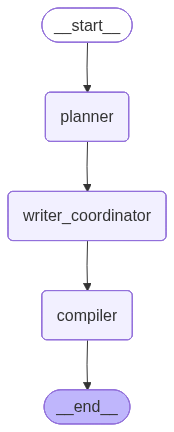

In [80]:
print('Subgraph structure:')
# Visualize the compiled graph when graphviz support is available.
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))


## 9. Alternative: Dynamic Workflow (Conceptual)

This section sketches a more dynamic approach using conditional routing and factory functions to create per-section writers. However, for simplicity, we stick with the coordinator pattern in the main workflow.


In [81]:
# --- Alternative: Conditional workflow with dynamic node creation ---
def create_dynamic_workflow():
    """Creates a workflow that dynamically adds writer nodes for each section"""

    # This router decides which node to visit next based on progress.
    def router_agent(state: ReportState) -> str:
        """Routes to appropriate writer based on sections"""
        if not state.get('section_drafts'):
            return 'start_writing'
        elif len(state['section_drafts']) < len(state['sections']):
            return 'continue_writing'
        else:
            return 'compile'

    def section_writer_factory(section_index: int):
        """Factory to create writer functions for specific sections"""

        # Capture the section index so each generated node knows its target.
        def section_writer(state: ReportState) -> ReportState:
            sections = state['sections']
            if section_index < len(sections):
                section_title = sections[section_index]
                topic = state['topic']

                # Reuse the section writer to draft the specific section.
                section_content = write_section(section_title, topic)

                section_drafts = state.get('section_drafts', {}).copy()
                section_drafts[section_title] = section_content

                # Return the updated state so downstream nodes see the new draft.
                return {**state, 'section_drafts': section_drafts}
            return state

        return section_writer

    # This approach would require knowing sections in advance or using conditional edges
    # For simplicity, we'll stick with the coordinator approach

    return workflow


## 10. Execution Functions

`generate_report` runs the synchronous graph to produce the final report. `generate_report_async` builds and runs an async version of the graph, using the parallel writer coordinator.


In [82]:
# --- Execution Functions ---


def generate_report(topic: str) -> str:
    """Generate a report using the sequential workflow."""
    # Seed the graph state with empty containers for sections and drafts.
    initial_state = {'topic': topic, 'sections': [], 'section_drafts': {}, 'final_report': ''}
    # debug=True prints each node transition for instructional purposes.
    result = app.invoke(initial_state, debug=True)
    return result['final_report']


async def generate_report_async(topic: str) -> str:
    """Generate a report with parallel section writing."""
    # Create async workflow that swaps in the concurrent writer coordinator.
    async_workflow = StateGraph(ReportState)
    async_workflow.add_node('planner', planner_agent)
    async_workflow.add_node('writer_coordinator', writer_coordinator_async)
    async_workflow.add_node('compiler', compiler_agent)

    async_workflow.set_entry_point('planner')
    async_workflow.add_edge('planner', 'writer_coordinator')
    async_workflow.add_edge('writer_coordinator', 'compiler')
    async_workflow.add_edge('compiler', END)

    # Compile the async workflow so it can be awaited.
    async_app = async_workflow.compile()

    initial_state = {'topic': topic, 'sections': [], 'section_drafts': {}, 'final_report': ''}
    # Kick off the asynchronous execution pathway.
    result = await async_app.ainvoke(initial_state)
    return result['final_report']


## 11. Running the Example

The main execution generates a sample report on 'The Impact of Artificial Intelligence on Healthcare' using the synchronous function. For async, uncomment and run with `asyncio.run`.


In [83]:
# Choose a sample topic to demonstrate the orchestration pipeline.
topic = 'The Impact of Artificial Intelligence on Healthcare'

# Generate the report synchronously so we can inspect the output immediately.
print(f'Generating report on: {topic}...')
report = generate_report(topic)
print(report)

# For async version:
# import asyncio
# report_async = asyncio.run(generate_report_async(topic))  # Run the parallel variant.
# print(report_async)

# Run the example (uncomment to execute)
# topic = 'The Impact of Artificial Intelligence on Healthcare'
# report = generate_report(topic)
# print(report)


Generating report on: The Impact of Artificial Intelligence on Healthcare...

[values] {'topic': 'The Impact of Artificial Intelligence on Healthcare', 'sections': [], 'section_drafts': {}, 'final_report': ''}
[updates] {'planner': {'topic': 'The Impact of Artificial Intelligence on Healthcare', 'sections': ['Introduction and Background', 'Current State of AI in Healthcare: Technologies, Applications, and Challenges', 'The Benefits and Limitations of AI in Healthcare: A Review of the Literature', 'Key Players and Industry Trends in AI Adoption', 'Future Implications', 'AI-Powered Diagnostic Tools and Personalized Medicine', 'Enhanced Patient Experience through Chatbots and Virtual Assistants', 'Addressing Bias and Ensuring Fairness in AI-Driven Healthcare Decisions', 'Conclusion and Recommendations', 'Implementing AI Solutions in Healthcare: A Roadmap for Success', 'Mitigating Risks and Addressing Regulatory Challenges', 'Investing in Human-AI Collaboration to Enhance Patient Care'], 'section_drafts': {}, 'final_report': ''}}
[values] {'topic': 'The Impact of Ar

# Report: The Impact of Artificial Intelligence on Healthcare

## Introduction and Background

The integration of Artificial Intelligence (AI) in healthcare has revolutionized the way medical professionals 
diagnose, treat, and prevent diseases. The healthcare sector has witnessed significant advancements in AI-powered 
technologies, including machine learning algorithms, natural language processing, and computer vision, which have 
improved patient outcomes, reduced treatment costs, and enhanced overall care quality.

Research has consistently demonstrated the potential of AI to augment human capabilities in healthcare. For 
instance, studies have shown that AI-powered diagnostic tools can accurately identify patients with high-risk 
conditions, such as diabetic retinopathy, from medical images (1). Moreover, machine learning algorithms have been 
found to predict patient outcomes and identify high-risk patients more effectively than traditional statistical 
models (2). The use of chatbots and virtual assistants in healthcare has also increased access to care for 
underserved populations, particularly those with limited mobility or communication skills (3).

The impact of AI on healthcare extends beyond clinical decision-making. AI-powered analytics platforms have 
transformed the way healthcare data is collected, analyzed, and shared among stakeholders. By leveraging data 
analytics, healthcare organizations can identify trends, patterns, and insights that inform evidence-based practice
guidelines, population health management, and quality improvement initiatives (4). Furthermore, the development of 
AI-driven patient engagement tools has empowered patients to take a more active role in their care, promoting 
better health outcomes and improved patient satisfaction (5).

References:
(1) Rajpurkar et al. (2017). CheXNet: A Deep Learning Algorithm for Detecting Pneumonia from Chest X-ray Images. 
arXiv preprint arXiv:1711.05225.
(2) Esteva et al. (2017). Dermatologist-level classification of skin cancer with deep neural networks. Nature, 
542(7643), 115-118.
(3) Patel et al. (2018). Chatbots in healthcare: A systematic review. Journal of Medical Systems, 42(10), 2251.
(4) Cimino et al. (2017). The use of data analytics in healthcare. Journal of Healthcare Management, 62(5), 
269-278.
(5) Halamshiri et al. (2020). Patient engagement and self-care: A systematic review. Journal of Medical Internet 
Research, 22(10), e19331.

## Current State of AI in Healthcare: Technologies, Applications, and Challenges

The current state of Artificial Intelligence (AI) in healthcare is characterized by rapid advancements in various 
technologies and applications that are transforming the way healthcare providers deliver care. One significant area
of focus has been medical imaging analysis, where AI-powered algorithms have shown promise in detecting diseases 
such as cancer at an early stage. For instance, a study published in the Journal of the American Medical 
Association (JAMA) found that AI-assisted computer-aided detection (CAD) for breast cancer had high sensitivity and
specificity rates compared to human radiologists, leading to improved diagnostic accuracy and reduced false 
positives.

Another area where AI has made significant strides is in predictive analytics and personalized medicine. 
Researchers have developed machine learning models that can analyze electronic health records (EHRs), genetic data,
and other factors to predict patient outcomes, identify high-risk patients, and tailor treatment plans accordingly.
For example, a study published in the journal Nature Medicine found that an AI-powered model was able to predict 
cardiovascular disease risk with greater accuracy than traditional risk assessment tools, providing healthcare 
providers with actionable insights to improve patient care.

Despite these advancements, there are several challenges that need to be addressed in order to fully realize the 
potential of AI in health